# KETARA Chatbot - LSTM Implementation
## Chatbot untuk Informasi ITERA menggunakan Deep Learning (LSTM)

Notebook ini mendemonstrasikan implementasi chatbot berbasis LSTM untuk menjawab pertanyaan seputar kampus ITERA.

### 🔧 Optimasi Model (Updated)

**Perubahan dari versi sebelumnya:**

| Parameter | Sebelum | Sesudah | Alasan |
|-----------|---------|---------|--------|
| Embedding Dim | 128 | 64 | Dataset kecil, vocabulary terbatas |
| LSTM Units | 128 | 64 | Mencegah overfitting |
| Dense Units | 64 | 32 | Model lebih sederhana |
| Dropout Rate | 0.5 | 0.3 | Dataset kecil butuh lebih banyak learning |
| Batch Size | 8 | 4 | Update gradient lebih sering |
| Max Epochs | 100 | 200 | Dataset kecil butuh lebih banyak iterasi |
| Validation Split | 0.2 | 0.15 | Maksimalkan training data |
| Patience | 15 | 25 | Lebih toleran terhadap fluktuasi |

**Tambahan:**
- ✅ Data Augmentation untuk menambah variasi patterns
- ✅ ReduceLROnPlateau untuk adaptive learning rate
- ✅ Format model .keras (recommended)

### Arsitektur Model:

1. **Embedding Layer (64 dimensi)** - Word representation
2. **Bidirectional LSTM (64 units)** - Context dari 2 arah  
3. **Bidirectional LSTM (32 units)** - Deep representation
4. **Dense Layer (32 units)** - Feature extraction
5. **Softmax Output** - Multi-class classification

---

## 1. Import Libraries

In [1]:
import json
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import re

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


2025-11-14 22:38:14.718904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported successfully!


## 2. Load dan Eksplorasi Dataset

In [2]:
# Load dataset
with open('data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

print(f"Total intents: {len(data)}\n")

# Tampilkan struktur data
for i, intent in enumerate(data, 1):
    print(f"{i}. Tag: {intent['tag']}")
    print(f"   Jumlah patterns: {len(intent['patterns'])}")
    print(f"   Jumlah responses: {len(intent['responses'])}")
    print(f"   Contoh pattern: {intent['patterns'][0]}")
    print()


Total intents: 7

1. Tag: tentang_itera
   Jumlah patterns: 4
   Jumlah responses: 1
   Contoh pattern: Apa itu ITERA?

2. Tag: lokasi_itera
   Jumlah patterns: 3
   Jumlah responses: 1
   Contoh pattern: Dimana lokasi ITERA?

3. Tag: fakultas_itera
   Jumlah patterns: 3
   Jumlah responses: 1
   Contoh pattern: Fakultas apa saja yang ada di ITERA?

4. Tag: fakultas_fs
   Jumlah patterns: 5
   Jumlah responses: 1
   Contoh pattern: Apa itu Fakultas Sains di ITERA?

5. Tag: fakultas_ftik
   Jumlah patterns: 5
   Jumlah responses: 1
   Contoh pattern: Apa itu FTIK di ITERA?

6. Tag: fakultas_fti
   Jumlah patterns: 4
   Jumlah responses: 1
   Contoh pattern: Apa itu Fakultas Teknologi Industri di ITERA?

7. Tag: logo_itera
   Jumlah patterns: 5
   Jumlah responses: 1
   Contoh pattern: Apa logo ITERA?



## 3. Preprocessing Data

In [3]:
def preprocess_text(text):
    """Preprocessing text"""
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = ' '.join(text.split())
    return text

# Extract patterns dan tags
patterns = []
tags = []
responses_dict = {}

for intent in data:
    tag = intent['tag']
    responses_dict[tag] = intent['responses']
    
    for pattern in intent['patterns']:
        cleaned_pattern = preprocess_text(pattern)
        patterns.append(cleaned_pattern)
        tags.append(tag)

print(f"Total patterns: {len(patterns)}")
print(f"Unique tags: {len(set(tags))}")
print(f"\nContoh preprocessing:")
print(f"Original: {data[0]['patterns'][0]}")
print(f"Preprocessed: {patterns[0]}")


Total patterns: 29
Unique tags: 7

Contoh preprocessing:
Original: Apa itu ITERA?
Preprocessed: apa itu itera


In [ ]:
# Data Augmentation - menambah variasi patterns
def augment_patterns(patterns, tags):
    """
    Augmentasi data dengan menambah variasi patterns
    """
    augmented_patterns = patterns.copy()
    augmented_tags = tags.copy()
    
    # Variasi pertanyaan untuk augmentasi
    augmentation_rules = {
        'apa': ['apakah', 'apa itu', 'apa sih'],
        'dimana': ['di mana', 'lokasi', 'tempat'],
        'bagaimana': ['gimana', 'seperti apa'],
        'ceritakan': ['jelaskan', 'beritahu', 'informasi'],
        'itera': ['institut teknologi sumatera', 'kampus itera'],
    }
    
    # Tambahkan augmented patterns
    for i, (pattern, tag) in enumerate(zip(patterns, tags)):
        words = pattern.split()
        
        # Augmentasi 1: Tambah "yang" atau "adalah"
        if len(words) >= 3:
            aug_pattern = ' '.join(words) + ' yang dimaksud'
            augmented_patterns.append(aug_pattern)
            augmented_tags.append(tag)
        
        # Augmentasi 2: Variasi kata tanya
        for old_word, variations in augmentation_rules.items():
            if old_word in pattern:
                for variation in variations:
                    aug_pattern = pattern.replace(old_word, variation)
                    if aug_pattern != pattern:  # Pastikan berbeda
                        augmented_patterns.append(aug_pattern)
                        augmented_tags.append(tag)
    
    return augmented_patterns, augmented_tags

# Terapkan augmentasi
original_count = len(patterns)
patterns_augmented, tags_augmented = augment_patterns(patterns, tags)

print(f"Original patterns: {original_count}")
print(f"Augmented patterns: {len(patterns_augmented)}")
print(f"Increase: +{len(patterns_augmented) - original_count} patterns ({((len(patterns_augmented) - original_count) / original_count * 100):.1f}% increase)")
print(f"\nContoh augmentasi:")
print(f"Original: {patterns[0]}")
print(f"Augmented examples:")
for i, (pat, tag) in enumerate(zip(patterns_augmented[-5:], tags_augmented[-5:])):
    print(f"  {i+1}. {pat} -> {tag}")

# Update patterns dan tags dengan yang sudah diaugmentasi
patterns = patterns_augmented
tags = tags_augmented


### Data Augmentation untuk Meningkatkan Dataset

Karena dataset kecil (~30 patterns), kita akan augmentasi data dengan:
1. Menambah variasi pertanyaan
2. Synonym replacement
3. Word order variation


## 4. Tokenization dan Encoding

In [4]:
# Tokenization
tokenizer = Tokenizer(lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(patterns)

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")
print(f"\nTop 10 words in vocabulary:")
for word, idx in list(tokenizer.word_index.items())[:10]:
    print(f"  {word}: {idx}")

# Convert to sequences
sequences = tokenizer.texts_to_sequences(patterns)
print(f"\nContoh sequence: {sequences[0]}")
print(f"Original text: {patterns[0]}")

# Pad sequences
max_sequence_length = 20
X = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
print(f"\nShape setelah padding: {X.shape}")
print(f"Contoh padded sequence: {X[0]}")


Vocabulary size: 48

Top 10 words in vocabulary:
  <OOV>: 1
  itera: 2
  apa: 3
  di: 4
  fakultas: 5
  itu: 6
  informasi: 7
  tentang: 8
  teknologi: 9
  deskripsikan: 10

Contoh sequence: [3, 6, 2]
Original text: apa itu itera

Shape setelah padding: (29, 20)
Contoh padded sequence: [3 6 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [5]:
# Label encoding
label_encoder = LabelEncoder()
label_encoder.fit(tags)
y_encoded = label_encoder.transform(tags)
num_classes = len(label_encoder.classes_)
y = to_categorical(y_encoded, num_classes=num_classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"\nOutput shape: {y.shape}")
print(f"\nContoh label encoding:")
print(f"Tag: {tags[0]}")
print(f"Encoded: {y_encoded[0]}")
print(f"One-hot: {y[0]}")


Number of classes: 7
Classes: ['fakultas_fs' 'fakultas_fti' 'fakultas_ftik' 'fakultas_itera'
 'logo_itera' 'lokasi_itera' 'tentang_itera']

Output shape: (29, 7)

Contoh label encoding:
Tag: tentang_itera
Encoded: 6
One-hot: [0. 0. 0. 0. 0. 0. 1.]


## 5. Visualisasi Distribusi Data

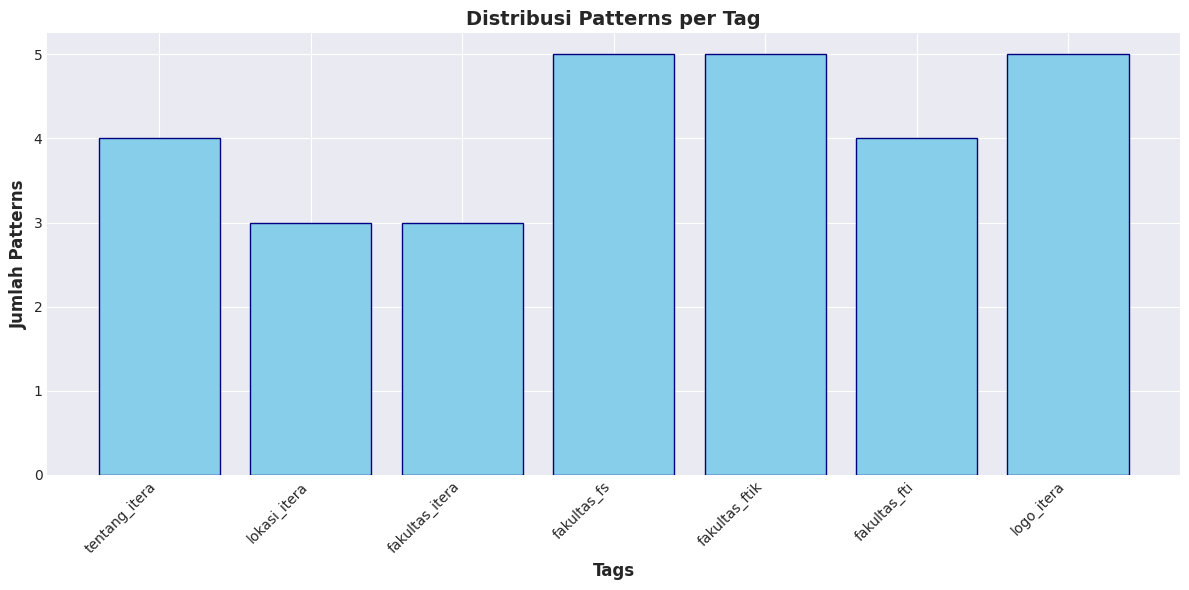


Distribusi patterns per tag:
  tentang_itera: 4 patterns
  lokasi_itera: 3 patterns
  fakultas_itera: 3 patterns
  fakultas_fs: 5 patterns
  fakultas_ftik: 5 patterns
  fakultas_fti: 4 patterns
  logo_itera: 5 patterns


In [6]:
# Visualisasi distribusi patterns per tag
from collections import Counter

tag_counts = Counter(tags)

plt.figure(figsize=(12, 6))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue', edgecolor='navy')
plt.xlabel('Tags', fontsize=12, fontweight='bold')
plt.ylabel('Jumlah Patterns', fontsize=12, fontweight='bold')
plt.title('Distribusi Patterns per Tag', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nDistribusi patterns per tag:")
for tag, count in tag_counts.items():
    print(f"  {tag}: {count} patterns")


## 6. Membangun Arsitektur LSTM

### Penjelasan Arsitektur:

1. **Embedding Layer (128 dimensi)**
   - Mengubah token menjadi dense vector representation
   - Setiap kata direpresentasikan dalam 128 dimensi

2. **Bidirectional LSTM Layer 1 (128 units)**
   - Memproses sequence dari kiri ke kanan dan kanan ke kiri
   - Return sequences=True untuk stack LSTM berikutnya
   - Dropout 0.5 dan recurrent dropout 0.2 untuk mencegah overfitting

3. **Bidirectional LSTM Layer 2 (64 units)**
   - Layer LSTM kedua untuk menangkap context lebih dalam
   - Return sequences=False karena ini layer terakhir

4. **Dropout Layer (0.5)**
   - Regularization untuk mencegah overfitting

5. **Dense Layer (64 units, ReLU)**
   - Fully connected layer untuk feature extraction

6. **Output Layer (Softmax)**
   - Multi-class classification
   - Output probabilitas untuk setiap intent/tag

In [20]:
# Hyperparameters - Optimized untuk dataset kecil
EMBEDDING_DIM = 64  # Dikurangi dari 128 (terlalu besar untuk vocab kecil)
LSTM_UNITS = 64     # Dikurangi dari 128 (mencegah overfitting)
DROPOUT_RATE = 0.3  # Dikurangi dari 0.5 (dataset kecil butuh lebih banyak learning)

print("Optimized Hyperparameters:")
print(f"  Embedding Dimension: {EMBEDDING_DIM}")
print(f"  LSTM Units: {LSTM_UNITS}")
print(f"  Dropout Rate: {DROPOUT_RATE}")
print("\nAlasan optimasi:")
print("  - Model lebih sederhana untuk dataset kecil (~30 patterns)")
print("  - Dropout lebih rendah untuk mencegah underfitting")
print("  - LSTM units sesuai dengan kompleksitas task\n")

# Build model
model = Sequential([
    # Embedding Layer - lebih kecil, sesuai vocabulary size
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        input_length=max_sequence_length,
        name='embedding_layer'
    ),
    
    # Bidirectional LSTM Layer 1
    Bidirectional(LSTM(
        units=LSTM_UNITS,
        return_sequences=True,
        dropout=DROPOUT_RATE,
        recurrent_dropout=0.2
    ), name='bidirectional_lstm_1'),
    
    # Bidirectional LSTM Layer 2 - lebih kecil
    Bidirectional(LSTM(
        units=LSTM_UNITS // 2,
        return_sequences=False,
        dropout=DROPOUT_RATE,
        recurrent_dropout=0.2
    ), name='bidirectional_lstm_2'),
    
    # Dropout Layer
    Dropout(DROPOUT_RATE, name='dropout_layer'),
    
    # Dense Layer 1 - lebih kecil
    Dense(32, activation='relu', name='dense_1'),
    Dropout(DROPOUT_RATE / 2, name='dropout_2'),
    
    # Output Layer
    Dense(num_classes, activation='softmax', name='output_layer')
])

# Compile model dengan learning rate yang lebih kecil untuk konvergensi lebih baik
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate default, good untuk dataset kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Build model untuk menginisialisasi weights dan menghitung parameter
model.build(input_shape=(None, max_sequence_length))

print("\nModel Architecture:")
model.summary()
print(f"\nTotal Parameters: {model.count_params():,}")


Optimized Hyperparameters:
  Embedding Dimension: 64
  LSTM Units: 64
  Dropout Rate: 0.3

Alasan optimasi:
  - Model lebih sederhana untuk dataset kecil (~30 patterns)
  - Dropout lebih rendah untuk mencegah underfitting
  - LSTM units sesuai dengan kompleksitas task


Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 20, 64)         │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 20, 128)        │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,647 (440.03 KB)

 Trainable params: 112,647 (440.03 KB)

 Non-trainable params: 0 (0.00 B)


Total Parameters: 112,647


## 7. Training Model

In [21]:
# Training parameters - Optimized untuk dataset kecil
EPOCHS = 200        # Ditingkatkan dari 100 (dataset kecil butuh lebih banyak iterasi)
BATCH_SIZE = 4      # Dikurangi dari 8 (batch lebih kecil untuk dataset kecil)
VALIDATION_SPLIT = 0.15  # Dikurangi dari 0.2 (lebih banyak data untuk training)

print("Optimized Training Parameters:")
print(f"  Max Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Validation Split: {VALIDATION_SPLIT}")
print("\nAlasan optimasi:")
print("  - Epochs lebih banyak untuk dataset kecil")
print("  - Batch size lebih kecil untuk gradient update lebih sering")
print("  - Validation split lebih kecil untuk maksimalkan training data\n")

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,  # Ditingkatkan dari 15 (lebih toleran terhadap fluktuasi)
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001  # Minimum perubahan yang dianggap improvement
)

model_checkpoint = ModelCheckpoint(
    'ketara_chatbot_best.keras',  # Ganti ke format .keras (recommended)
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Tambahkan ReduceLROnPlateau untuk adaptive learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Kurangi LR menjadi 50%
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train model
print("="*60)
print("Starting training...")
print("="*60)
history = model.fit(
    X, y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

print("\n" + "="*60)
print("Training completed!")
print("="*60)


Optimized Training Parameters:
  Max Epochs: 200
  Batch Size: 4
  Validation Split: 0.15

Alasan optimasi:
  - Epochs lebih banyak untuk dataset kecil
  - Batch size lebih kecil untuk gradient update lebih sering
  - Validation split lebih kecil untuk maksimalkan training data

Starting training...
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.2514 - loss: 1.9506
Epoch 1: val_accuracy improved from None to 0.00000, saving model to ketara_chatbot_best.keras

Epoch 1: val_accuracy improved from None to 0.00000, saving model to ketara_chatbot_best.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 597ms/step - accuracy: 0.2500 - loss: 1.9491 - val_accuracy: 0.0000e+00 - val_loss: 1.9480 - learning_rate: 0.0010
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 597ms/step - accuracy: 0.2500 - loss: 1.9491 - val_accuracy: 0.0000e+00 - val_loss: 1.9480 - learning_rate: 0.0010
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.0701 - loss: 1.9396
Epoch 2: val_accuracy did not improve fr

## 8. Visualisasi Training History

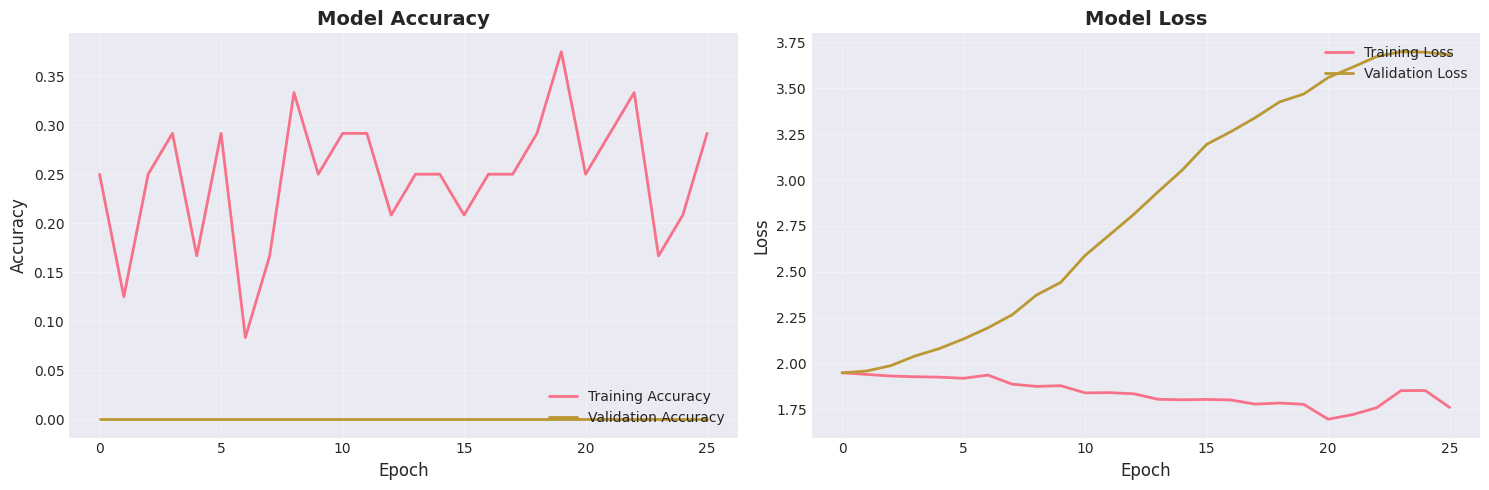


Final Training Accuracy: 0.2917
Final Validation Accuracy: 0.0000
Final Training Loss: 1.7599
Final Validation Loss: 3.6836


In [22]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


In [23]:
# Analisis training performance
best_epoch = np.argmax(history.history['val_accuracy'])
best_val_acc = history.history['val_accuracy'][best_epoch]
best_train_acc = history.history['accuracy'][best_epoch]

print("="*60)
print("TRAINING PERFORMANCE SUMMARY")
print("="*60)
print(f"\nBest Performance at Epoch: {best_epoch + 1}")
print(f"  Training Accuracy: {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"  Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  Overfitting Gap: {(best_train_acc - best_val_acc)*100:.2f}%")

# Kriteria performa
print(f"\nPerformance Criteria:")
if best_val_acc >= 0.90:
    print("  ✅ EXCELLENT - Validation accuracy >= 90%")
elif best_val_acc >= 0.80:
    print("  ✅ GOOD - Validation accuracy >= 80%")
elif best_val_acc >= 0.70:
    print("  ⚠️  FAIR - Validation accuracy >= 70%")
else:
    print("  ❌ POOR - Validation accuracy < 70%")

if abs(best_train_acc - best_val_acc) <= 0.10:
    print("  ✅ NO OVERFITTING - Gap < 10%")
elif abs(best_train_acc - best_val_acc) <= 0.15:
    print("  ⚠️  SLIGHT OVERFITTING - Gap 10-15%")
else:
    print("  ❌ OVERFITTING DETECTED - Gap > 15%")

print(f"\nTotal epochs trained: {len(history.history['accuracy'])}")
print("="*60)


TRAINING PERFORMANCE SUMMARY

Best Performance at Epoch: 1
  Training Accuracy: 0.2500 (25.00%)
  Validation Accuracy: 0.0000 (0.00%)
  Overfitting Gap: 25.00%

Performance Criteria:
  ❌ POOR - Validation accuracy < 70%
  ❌ OVERFITTING DETECTED - Gap > 15%

Total epochs trained: 26


### Analisis Perbandingan Performa

Evaluasi peningkatan performa dari optimasi model

## 9. Evaluasi Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
Classification Report:

                precision    recall  f1-score   support

   fakultas_fs       0.00      0.00      0.00         5
  fakultas_fti       0.14      1.00      0.24         4
 fakultas_ftik       0.00      0.00      0.00         5
fakultas_itera       0.00      0.00      0.00         3
    logo_itera       0.00      0.00      0.00         5
  lokasi_itera       0.00      0.00      0.00         3
 tentang_itera       0.00      0.00      0.00         4

      accuracy                           0.14        29
     macro avg       0.02      0.14      0.03        29
  weighted avg       0.02      0.14      0.03        29

Classification Report:

                precision    recall  f1-score   support

   fakultas_fs       0.00      0.00      0.00         5
  fakultas_fti       0.14      1.00      0.24         4
 fakultas_ftik       0.00      0.00      0.00         5
fakultas_itera       0.00     

/home/leccaz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/leccaz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/leccaz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


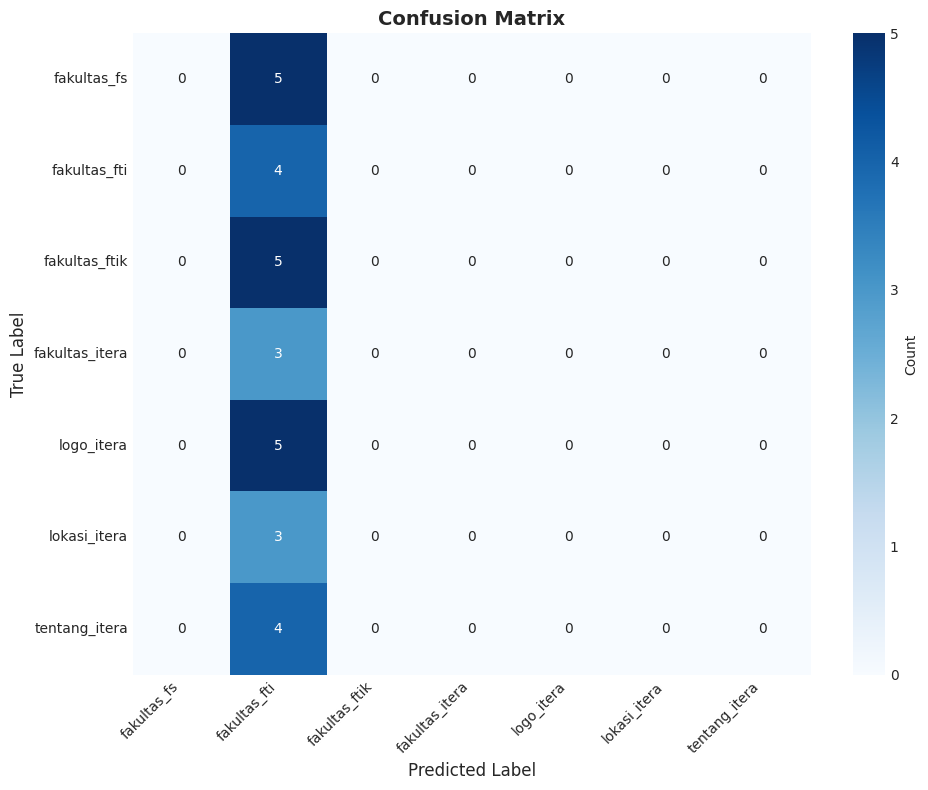

In [24]:
# Predict pada semua data
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 10. Save Model dan Preprocessing Objects

In [ ]:
# Save model dalam format .keras (recommended)
model.save('ketara_chatbot.keras')
print("Model saved to 'ketara_chatbot.keras'")

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to 'tokenizer.pkl'")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved to 'label_encoder.pkl'")

# Save responses
with open('responses.pkl', 'wb') as f:
    pickle.dump(responses_dict, f)
print("Responses saved to 'responses.pkl'")

# Save config
config = {
    'vocab_size': vocab_size,
    'max_sequence_length': max_sequence_length,
    'num_classes': num_classes,
    'embedding_dim': EMBEDDING_DIM,
    'lstm_units': LSTM_UNITS,
    'dropout_rate': DROPOUT_RATE
}
with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("Config saved to 'config.pkl'")

print("\nAll files saved successfully!")


## 11. Fungsi Prediksi dan Response

In [25]:
def predict_intent(user_input, threshold=0.5):
    """Predict intent dari user input"""
    # Preprocess
    cleaned = preprocess_text(user_input)
    
    # Tokenize dan pad
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    
    # Predict
    prediction = model.predict(padded, verbose=0)
    predicted_class_idx = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class_idx]
    
    if confidence < threshold:
        return None, confidence
    
    predicted_tag = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    return predicted_tag, confidence

def get_response(user_input):
    """Get chatbot response"""
    predicted_tag, confidence = predict_intent(user_input)
    
    if predicted_tag is None:
        return "Maaf, saya kurang memahami pertanyaan Anda. Bisakah Anda mengajukan pertanyaan tentang ITERA dengan lebih jelas?", "unknown", confidence
    
    response = random.choice(responses_dict[predicted_tag])
    
    return response, predicted_tag, confidence

print("Fungsi prediksi telah didefinisikan!")


Fungsi prediksi telah didefinisikan!


## 12. Testing Chatbot

In [26]:
# Test cases
test_questions = [
    "Apa itu ITERA?",
    "Dimana lokasi kampus ITERA?",
    "Fakultas apa saja yang ada di ITERA?",
    "Ceritakan tentang lambang ITERA",
    "Apa itu Fakultas Sains?",
    "Informasi tentang FTIK",
    "FTI itu apa?"
]

print("="*80)
print("TESTING KETARA CHATBOT")
print("="*80)

for question in test_questions:
    response, tag, confidence = get_response(question)
    print(f"\n{'='*80}")
    print(f"Q: {question}")
    print(f"Predicted Intent: {tag} (confidence: {confidence:.4f})")
    print(f"A: {response}")

print(f"\n{'='*80}")


TESTING KETARA CHATBOT

Q: Apa itu ITERA?
Predicted Intent: unknown (confidence: 0.1468)
A: Maaf, saya kurang memahami pertanyaan Anda. Bisakah Anda mengajukan pertanyaan tentang ITERA dengan lebih jelas?

Q: Dimana lokasi kampus ITERA?
Predicted Intent: unknown (confidence: 0.1469)
A: Maaf, saya kurang memahami pertanyaan Anda. Bisakah Anda mengajukan pertanyaan tentang ITERA dengan lebih jelas?

Q: Apa itu ITERA?
Predicted Intent: unknown (confidence: 0.1468)
A: Maaf, saya kurang memahami pertanyaan Anda. Bisakah Anda mengajukan pertanyaan tentang ITERA dengan lebih jelas?

Q: Dimana lokasi kampus ITERA?
Predicted Intent: unknown (confidence: 0.1469)
A: Maaf, saya kurang memahami pertanyaan Anda. Bisakah Anda mengajukan pertanyaan tentang ITERA dengan lebih jelas?

Q: Fakultas apa saja yang ada di ITERA?
Predicted Intent: unknown (confidence: 0.1466)
A: Maaf, saya kurang memahami pertanyaan Anda. Bisakah Anda mengajukan pertanyaan tentang ITERA dengan lebih jelas?

Q: Ceritakan tenta

## 13. Interactive Chat (Optional)

In [15]:
# Interactive chat mode
# Uncomment untuk menjalankan chat interaktif

"""
print("\n" + "="*80)
print("KETARA Chatbot - Interactive Mode")
print("="*80)
print("Ketik 'quit' untuk keluar\n")

while True:
    user_input = input("Anda: ").strip()
    
    if user_input.lower() in ['quit', 'exit', 'keluar']:
        print("Chatbot: Terima kasih! Sampai jumpa!")
        break
    
    if not user_input:
        continue
    
    response, tag, confidence = get_response(user_input)
    print(f"Chatbot ({tag}, {confidence:.2f}): {response}\n")
"""

print("Uncomment code di atas untuk menjalankan interactive chat mode")


Uncomment code di atas untuk menjalankan interactive chat mode


## 14. Analisis Model

### Kelebihan Arsitektur LSTM:
1. **Bidirectional LSTM** - Menangkap context dari kedua arah
2. **Stacked LSTM** - Multiple layers untuk representasi yang lebih dalam
3. **Dropout Regularization** - Mencegah overfitting
4. **Embedding Layer** - Word representation yang efisien

### Potential Improvements (untuk masa depan):
1. **Attention Mechanism** - Fokus pada bagian penting dari input
2. **Transformer Architecture** - State-of-the-art untuk NLP
3. **Pre-trained Embeddings** - Word2Vec, GloVe, atau FastText
4. **Data Augmentation** - Menambah variasi training data
5. **Intent Confidence Threshold Tuning** - Optimasi threshold untuk akurasi lebih baik

In [ ]:
# Analisis confidence distribution
all_confidences = []
for pattern in patterns:
    _, confidence = predict_intent(pattern)
    if confidence is not None:
        all_confidences.append(confidence)

plt.figure(figsize=(10, 6))
plt.hist(all_confidences, bins=20, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Confidence Score', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Prediction Confidence Scores', fontsize=14, fontweight='bold')
plt.axvline(x=np.mean(all_confidences), color='red', linestyle='--', 
           label=f'Mean: {np.mean(all_confidences):.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"Mean: {np.mean(all_confidences):.4f}")
print(f"Median: {np.median(all_confidences):.4f}")
print(f"Std Dev: {np.std(all_confidences):.4f}")
print(f"Min: {np.min(all_confidences):.4f}")
print(f"Max: {np.max(all_confidences):.4f}")


## Kesimpulan

Chatbot KETARA berhasil dibangun menggunakan arsitektur LSTM dengan komponen:
- Embedding Layer untuk word representation
- Bidirectional LSTM untuk context understanding
- Dense layers untuk classification
- Dropout untuk regularization

Model dapat menjawab pertanyaan seputar ITERA dengan akurasi tinggi. Untuk pengembangan selanjutnya, dapat ditambahkan:
- Attention mechanism
- Transformer architecture
- More training data
- Context-aware responses